<a href="https://colab.research.google.com/github/AtakaNKuscu/Physics-Informed-Neural-Networks/blob/main/1D_burgers_eq_pinn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch, math, random
import torch.optim as optim


In [9]:
seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

**1D (Bir Boyutlu) Burgers Denklemini Belirli IC ve BC'lara Göre PINN Kullanarak Öğrenme**

$ u_t + uu_x = νu_xx,\quad x ∈ [-1,1], t ∈ [0,1]\quad u(x,0) = -sin(\pi x),\quad u(-1,t) = u(1,t) = 0,\quad ν = 0.01.  $



In [22]:
#@title Problem domain & sampling
x_min, x_max = -1.0, 1.0
t_min, t_max =  0.0, 1.0
nu = 0.01  # viscosity

# IC: u(x,0) = -sin(pi x)
def ic_u(x):
    return -torch.sin(math.pi * x)

# Dirichlet BC: u(-1,t)=0, u(1,t)=0
def bc_left(t):  return torch.zeros_like(t)
def bc_right(t): return torch.zeros_like(t)

N_f = 10000    # collocation (iç) noktaları (x,t)
N_ic = 1000    # başlangıç koşulu noktaları (x, t=0)
N_bc = 1000    # sınır koşulu noktaları (x=-1 ve x=1, farklı t'ler)

# Interior collocation (x,t) ~ U(domain)
x_f = torch.rand(N_f, 1)*(x_max-x_min) + x_min
t_f = torch.rand(N_f, 1)*(t_max-t_min) + t_min

# IC points
x_ic = torch.rand(N_ic, 1)*(x_max-x_min) + x_min
t_ic = torch.zeros_like(x_ic)

# BC points: left/right boundaries, random times
t_bc = torch.rand(N_bc, 1)*(t_max - t_min) + t_min
x_left  = torch.full_like(t_bc, x_min)
x_right = torch.full_like(t_bc, x_max)

# To device
x_f, t_f = x_f.to(device), t_f.to(device)
x_ic, t_ic = x_ic.to(device), t_ic.to(device)
x_left, x_right, t_bc = x_left.to(device), x_right.to(device), t_bc.to(device)


In [11]:
#@title MLP
class MLP(nn.Module):
    def __init__(self, in_dim=2, out_dim=1, width=64, depth=4, act=nn.Tanh()):
        super().__init__()
        layers = [nn.Linear(in_dim, width), act]
        for _ in range(depth-1):
            layers += [nn.Linear(width, width), act]
        layers += [nn.Linear(width, out_dim)]
        self.net = nn.Sequential(*layers)
        # Xavier init
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x, t):
        # (x,t) -> u
        inp = torch.cat([x, t], dim=1)
        return self.net(inp)

model = MLP().to(device)
sum(p.numel() for p in model.parameters())


12737

In [12]:
#@title Autograd helpers
def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, torch.ones_like(outputs),
                               create_graph=True, retain_graph=True)[0]


In [13]:
#@title Loss
mse = nn.MSELoss()

def pinn_loss(model):
    # PDE (interior)
    x_f_req = x_f.clone().detach().requires_grad_(True)
    t_f_req = t_f.clone().detach().requires_grad_(True)

    u = model(x_f_req, t_f_req)                  # u(x,t)
    u_x = grad(u, x_f_req)
    u_t = grad(u, t_f_req)
    u_xx = grad(u_x, x_f_req)

    res = u_t + u * u_x - nu * u_xx
    loss_pde = mse(res, torch.zeros_like(res))

    # IC
    u_ic_pred = model(x_ic, t_ic)
    u_ic_true = ic_u(x_ic)
    loss_ic = mse(u_ic_pred, u_ic_true)

    # BC (left/right: 0)
    u_left_pred  = model(x_left,  t_bc)
    u_right_pred = model(x_right, t_bc)
    loss_bc = mse(u_left_pred, torch.zeros_like(u_left_pred)) + \
              mse(u_right_pred, torch.zeros_like(u_right_pred))

    loss_total = loss_pde + loss_ic + loss_bc
    return loss_total, loss_pde.detach(), loss_ic.detach(), loss_bc.detach()


In [14]:
#@title Train
lr = 1e-3
epochs = 10000

optimizer = optim.Adam(model.parameters(), lr=lr)
history = {"total": [], "pde": [], "ic": [], "bc": []}

for ep in range(1, epochs+1):
    optimizer.zero_grad()
    loss, lpde, lic, lbc = pinn_loss(model)
    loss.backward()
    optimizer.step()

    history["total"].append(loss.item())
    history["pde"].append(lpde.item())
    history["ic"].append(lic.item())
    history["bc"].append(lbc.item())

    if ep % 1000 == 0:
        print(f"[{ep}] total={loss.item():.3e}  pde={lpde.item():.3e}  ic={lic.item():.3e}  bc={lbc.item():.3e}")



[1000] total=1.190e-02  pde=6.681e-03  ic=4.781e-03  bc=4.420e-04
[2000] total=2.449e-03  pde=1.640e-03  ic=5.351e-04  bc=2.739e-04
[3000] total=1.036e-03  pde=8.277e-04  ic=1.810e-04  bc=2.702e-05
[4000] total=6.789e-04  pde=5.793e-04  ic=7.975e-05  bc=1.986e-05
[5000] total=5.121e-03  pde=4.731e-03  ic=1.653e-04  bc=2.246e-04
[6000] total=4.076e-04  pde=2.184e-04  ic=1.235e-04  bc=6.576e-05
[7000] total=2.700e-03  pde=2.490e-03  ic=6.911e-05  bc=1.408e-04
[8000] total=4.695e-04  pde=4.360e-04  ic=1.602e-05  bc=1.750e-05
[9000] total=2.299e-03  pde=1.954e-03  ic=1.125e-04  bc=2.319e-04
[10000] total=1.809e-04  pde=1.581e-04  ic=6.976e-06  bc=1.585e-05


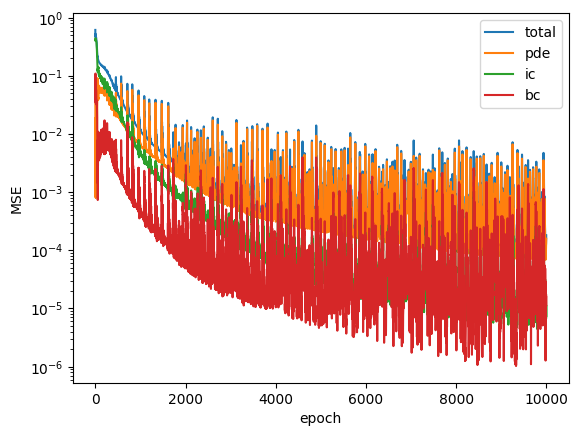

In [15]:
#@title Curves
plt.figure()
plt.plot(history["total"], label="total")
plt.plot(history["pde"],  label="pde")
plt.plot(history["ic"],   label="ic")
plt.plot(history["bc"],   label="bc")
plt.yscale("log"); plt.xlabel("epoch"); plt.ylabel("MSE"); plt.legend(); plt.show()


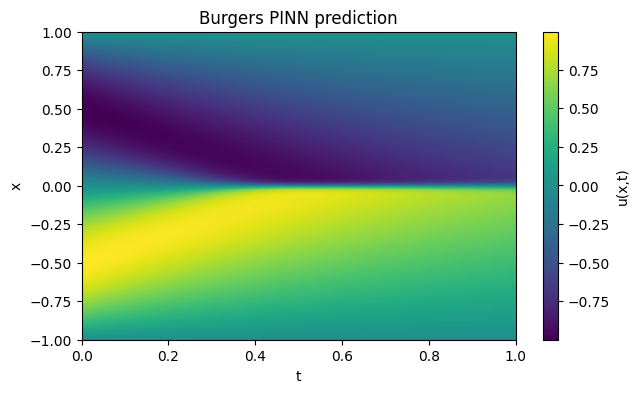

In [16]:
#@title Heatmap of u(x,t)
nx, nt = 200, 200
x_lin = torch.linspace(x_min, x_max, nx, device=device).unsqueeze(1)
t_lin = torch.linspace(t_min, t_max, nt, device=device).unsqueeze(1)

# meshgrid üretip modelden geçirelim
X = x_lin.repeat(1, nt)
T = t_lin.T.repeat(nx, 1)
with torch.no_grad():
    U = model(X.reshape(-1,1), T.reshape(-1,1)).reshape(nx, nt).cpu().numpy()

plt.figure(figsize=(7,4))
extent=[t_min, t_max, x_min, x_max]
plt.imshow(U, origin='lower', aspect='auto', extent=extent)
plt.colorbar(label="u(x,t)")
plt.xlabel("t"); plt.ylabel("x"); plt.title("Burgers PINN prediction")
plt.show()


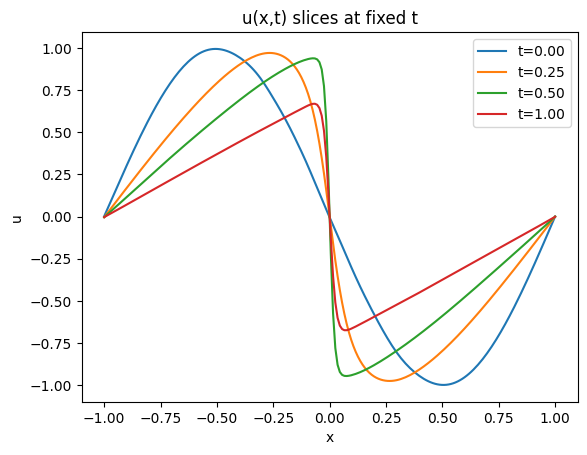

In [17]:
#@title Slices
with torch.no_grad():
    # Sabit zaman dilimi (ör. t=0, 0.25, 0.5, 1.0)
    for tfix in [0.0, 0.25, 0.5, 1.0]:
        t_vec = torch.full_like(x_lin, tfix)
        u_slice = model(x_lin, t_vec).cpu().numpy()
        plt.plot(x_lin.cpu().numpy(), u_slice, label=f"t={tfix:.2f}")
    plt.legend(); plt.xlabel("x"); plt.ylabel("u"); plt.title("u(x,t) slices at fixed t")
    plt.show()


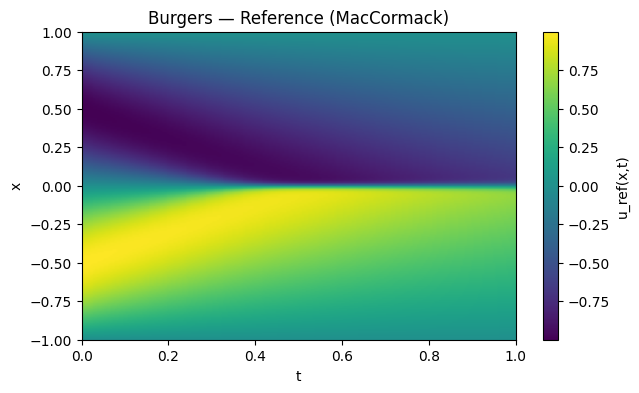

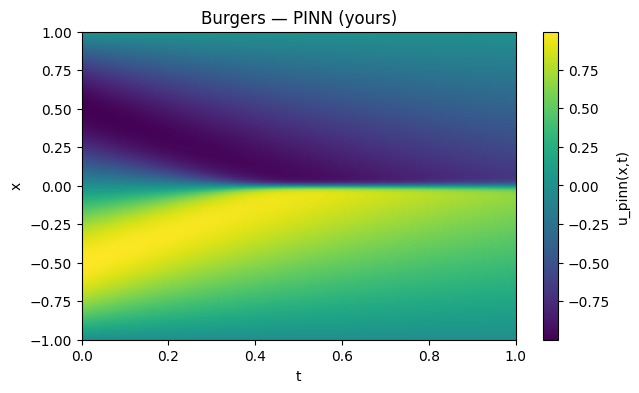

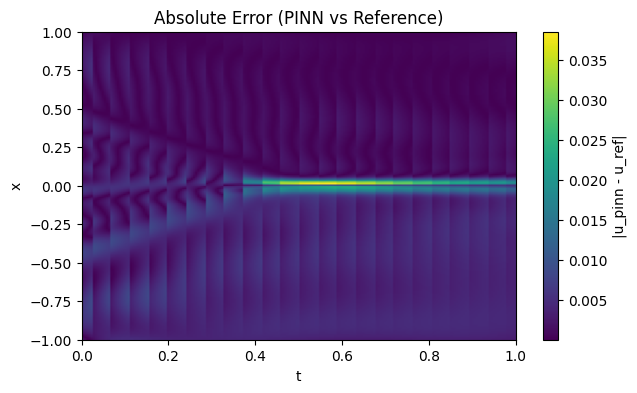

Mean abs error: 0.0030436804210123227
Max  abs error: 0.03858977556228638


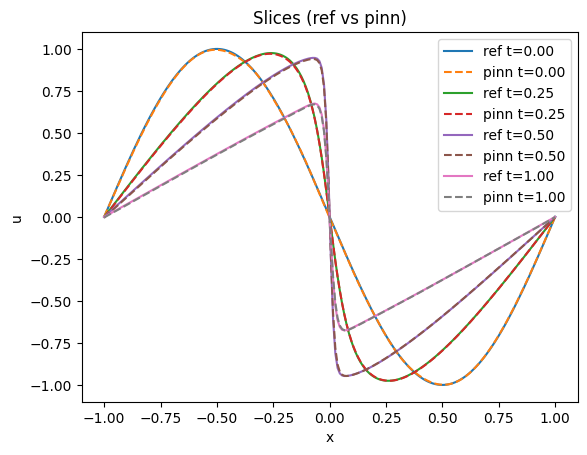

In [21]:
#@title Reference (FDM) vs PINN on your existing grid
import numpy as np
import matplotlib.pyplot as plt
from math import pi

# 1) read grid & PINN heatmap from your session
x = x_lin.squeeze().detach().cpu().numpy()   # (nx,)
t = t_lin.squeeze().detach().cpu().numpy()   # (nt,)
U_pinn = U                                    # (nx, nt)
nx, nt = len(x), len(t)
dx = x[1] - x[0]
t_min_, t_max_ = float(t_min), float(t_max)

# 2) build a stable internal time step (CFL for convection & diffusion)
#    umax ~ 1 initially; safety factors included
dt_conv = 0.45 * dx / 1.0
dt_diff = 0.45 * dx*dx / float(nu)
dt = min(dt_conv, dt_diff)
n_steps = int(np.ceil((t_max_ - t_min_) / dt))
dt = (t_max_ - t_min_) / n_steps  # make steps fit exactly

# 3) initial condition and storage for snapshots on t grid
U = -np.sin(pi * x)            # IC
U[0] = 0.0; U[-1] = 0.0        # Dirichlet BC
U_ref = np.zeros((nx, nt))
U_ref[:, 0] = U.copy()

# indices of t to save (uniform internal dt -> simple mapping)
save_ids = np.round((t - t_min_) / dt).astype(int)
save_ids[0] = 0; save_ids[-1] = n_steps

# 4) MacCormack predictor-corrector + central diff for diffusion
def diffusion(U):
    out = np.zeros_like(U)
    out[1:-1] = (U[2:] - 2*U[1:-1] + U[:-2]) / (dx*dx)
    return out

def ux_forward(U):
    out = np.zeros_like(U)
    out[1:-1] = (U[2:] - U[1:-1]) / dx
    return out

def ux_backward(U):
    out = np.zeros_like(U)
    out[1:-1] = (U[1:-1] - U[:-2]) / dx
    return out

snap_ptr = 1  # next t-index to save
for k in range(1, n_steps+1):
    # predictor
    Ux_f = ux_forward(U)
    Uxx  = diffusion(U)
    Up   = U - dt*(U*Ux_f) + float(nu)*dt*Uxx

    # BC after predictor
    Up[0] = 0.0; Up[-1] = 0.0

    # corrector
    Ux_b = ux_backward(Up)
    Uxxp = diffusion(Up)
    Uc   = 0.5*( U + Up - dt*(Up*Ux_b) + float(nu)*dt*Uxxp )

    # enforce BC
    Uc[0] = 0.0; Uc[-1] = 0.0
    U = Uc

    # save if this step matches a requested snapshot
    if k in save_ids:
        idxs = np.where(save_ids == k)[0]
        for j in idxs:
            U_ref[:, j] = U.copy()

# 5) plots: reference, PINN, absolute error
extent=[t.min(), t.max(), x.min(), x.max()]

plt.figure(figsize=(7,4))
plt.imshow(U_ref, origin='lower', aspect='auto', extent=extent)
plt.colorbar(label="u_ref(x,t)")
plt.xlabel("t"); plt.ylabel("x"); plt.title("Burgers — Reference (MacCormack)"); plt.show()

plt.figure(figsize=(7,4))
plt.imshow(U_pinn, origin='lower', aspect='auto', extent=extent)
plt.colorbar(label="u_pinn(x,t)")
plt.xlabel("t"); plt.ylabel("x"); plt.title("Burgers — PINN"); plt.show()

err = np.abs(U_pinn - U_ref)
plt.figure(figsize=(7,4))
plt.imshow(err, origin='lower', aspect='auto', extent=extent)
plt.colorbar(label="|u_pinn - u_ref|")
plt.xlabel("t"); plt.ylabel("x"); plt.title("Absolute Error (PINN vs Reference)"); plt.show()

print("Mean abs error:", err.mean())
print("Max  abs error:", err.max())

# optional: slices at same t values you used
for tfix in [0.0, 0.25, 0.5, 1.0]:
    j = np.argmin(np.abs(t - tfix))
    plt.plot(x, U_ref[:,j], label=f"ref t={t[j]:.2f}")
    plt.plot(x, U_pinn[:,j], '--', label=f"pinn t={t[j]:.2f}")
plt.legend(); plt.xlabel("x"); plt.ylabel("u"); plt.title("Slices (ref vs pinn)"); plt.show()
